# START of tensile data processing

In [1]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
import pandas as pds
from chxanalys.chx_libs import colors, markers

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
linkDir = '/XF11ID/analysis/2017_3/lwiegart/Link_files/Exports/'  # directory for link-data (exported from native format)
link_fn='uid_ce3b2b_SumitomoI 250um periodic 2s wait 15-10-17 22-00-39-10Exported.txt'
save_data=True   #save processed data to HDF5 file in linkDir

In [5]:
# function to be moved to analysis package
def get_echos(dat_arr,min_distance=10):
    """
    getting local maxima and minima from 1D data -> e.g. speckle echos
    strategy: using peak_local_max (from skimage) with min_distance parameter to find well defined local maxima
    using np.argmin to find absolute minima between relative maxima
    returns [max_ind,min_ind] -> lists of indices corresponding to local maxima/minima
    by LW 10/23/2018
    """
    from skimage.feature import peak_local_max
    max_ind=peak_local_max(dat_arr, min_distance)
    min_ind=[]
    for i in range(len(max_ind[:-1])):
        min_ind.append(max_ind[i+1][0]+np.argmin(dat_arr[max_ind[i+1][0]:max_ind[i][0]]))
    #unfortunately, skimage function fu$$s up the format: max_ind is an array of a list of lists...fix this:
    mmax_ind=[]
    for l in max_ind:
        mmax_ind.append(l[0])
    return [mmax_ind,min_ind]

<IPython.core.display.Javascript object>


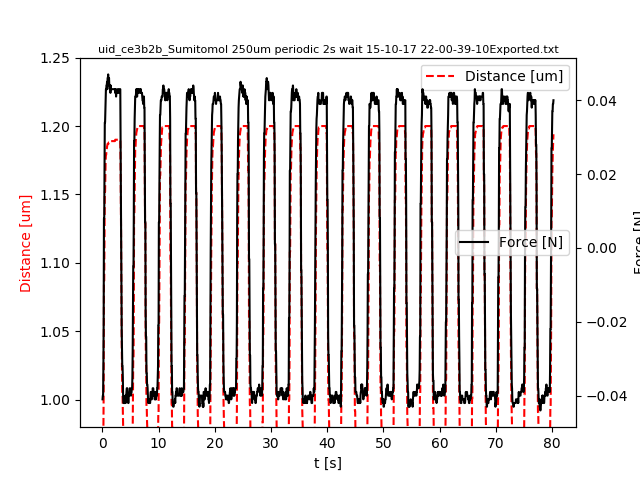

In [27]:
# getting link file data
good_cols = [ 1,2,4,6,8,10 ]
labels = [  'time', 'temperature', 'force', 'distance', 'stress', 'strain'  ]
good_line_pattern = "Index\tX\tY\tX\tY\tX\tY" 
df =  extract_data_from_file(  link_fn, linkDir, good_line_pattern, good_cols, labels)

#fig = plt.figure() #figsize=(7, 6)
fig,host=plt.subplots()
ax1 = host.twinx()

p1, = host.plot(df.time,df.distance,'r--', label="Distance [um]")
p2, = ax1.plot(df.time,df.force,'k-', label="Force [N]")

host.set_xlabel("t [s]")
host.set_ylabel('Distance [um]')
ax1.set_ylabel("Force [N]")
host.set_title(link_fn,fontsize=8)
host.set_ylim(.98,1.25)
host.legend(fontsize=10)
ax1.legend(fontsize=10)
host.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())

#plt.show()

In [7]:
#finding the top 1% and min 1% points:
[ind1,ind2]= get_echos(np.array(df.distance)[np.array(df.distance)-np.average(np.array(df.distance))>0],min_distance=5)
top_val=np.average(np.array(df.distance)[np.array(df.distance)-np.average(np.array(df.distance))>0][ind1])
top_ind=np.array(df.distance)>top_val*.99

[ind1,ind2]= get_echos(np.array(df.distance)[np.array(df.distance)-np.average(np.array(df.distance))<0],min_distance=5)
val_val=np.average(np.array(df.distance)[np.array(df.distance)-np.average(np.array(df.distance))<0][ind1])
val_ind=np.array(df.distance)<val_val*1.01

# getting average and PV for each of the FORCE 'clusters'...part I: corresponding to positive speckle echo:
a_min=[];a_max=[];a_mean=[];temp_a=[];temp_at=[];at=[];l=0
for i in top_ind:
    if i:
        temp_a.append(df.force[l])
        temp_at.append(df.time[l])
        l=l+1
    else:
        if not temp_a:
            l=l+1
        else:
            a_min.append(np.min(temp_a))
            a_max.append(np.max(temp_a))
            a_mean.append(np.average(temp_a))
            at.append(np.average(temp_at))
            temp_a=[]
            temp_at=[]
            l=l+1
# getting average and PV for each of the FORCE 'clusters'...part II: corresponding to negative speckle echo:
b_min=[];b_max=[];b_mean=[];temp_b=[];temp_bt=[];bt=[];l=0
for i in val_ind:
    if i:
        temp_b.append(df.force[l])
        temp_bt.append(df.time[l])
        l=l+1
    else:
        if not temp_b:
            l=l+1
        else:
            b_min.append(np.min(temp_b))
            b_max.append(np.max(temp_b))
            b_mean.append(np.average(temp_b))
            bt.append(np.average(temp_bt))
            temp_b=[]
            temp_bt=[]
            l=l+1  

<IPython.core.display.Javascript object>


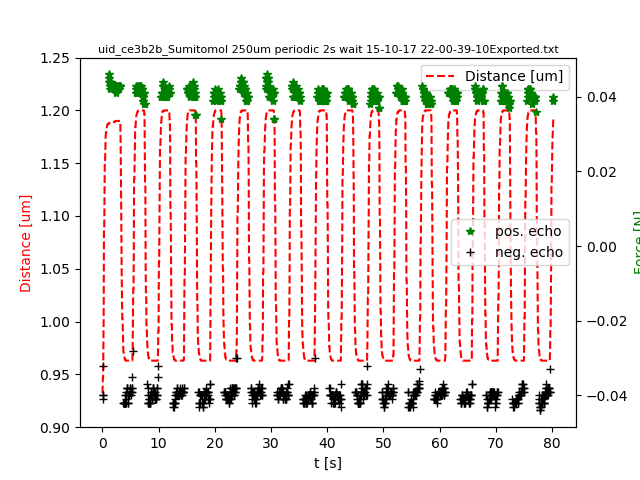

In [28]:
fig,host=plt.subplots()
ax1 = host.twinx()

p1, = host.plot(df.time,df.distance,'r--', label="Distance [um]")
p2, = ax1.plot(df.time[top_ind],df.force[top_ind],'g*', label="pos. echo")
p3, = ax1.plot(df.time[val_ind],df.force[val_ind],'k+', label="neg. echo")

host.set_xlabel("t [s]")
host.set_ylabel('Distance [um]')
ax1.set_ylabel("Force [N]")
host.set_title(link_fn,fontsize=8)
host.set_ylim(.9,1.25)
host.legend(fontsize=10)
ax1.legend(fontsize=10)
host.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())

<IPython.core.display.Javascript object>


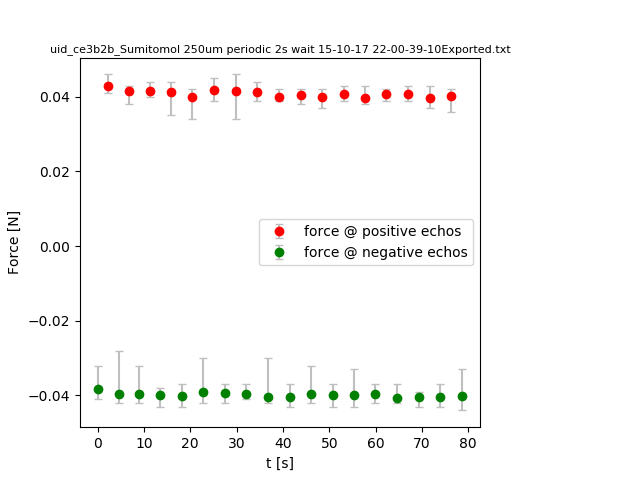

In [9]:
fig,ax=plt.subplots()
plt.errorbar(at, a_mean, yerr=abs(np.array([a_min,a_max])-a_mean), xerr=None, fmt='ro',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='force @ positive echos')
plt.errorbar(bt, b_mean, yerr=abs(np.array([b_min,b_max])-b_mean), xerr=None, fmt='go',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='force @ negative echos')
plt.xlabel('t [s]')
plt.ylabel('Force [N]')
plt.legend(fontsize=10)
plt.title(link_fn,fontsize=8)

In [10]:
# save the force-time data as .hdf5
if save_data:
    md=dict()
    md['link file']= linkDir + link_fn
    Exdt = {} 
    for k,v in zip( ['md', 'pos_echo_time','pos_echo_mean', 'pos_echo_min','pos_echo_max'], 
                   [md,       at, a_mean, a_min,a_max] ):
           Exdt[ k ] = v
    export_xpcs_results_to_h5( 'processed_'+link_fn, linkDir, export_dict = Exdt )
else:
    print('ATTENTION: DATA SAVING NOT ENABLED!')

The xpcs analysis results are exported to /XF11ID/analysis/2017_3/lwiegart/Link_files/Exports/ with filename as processed_uid_ce3b2b_SumitomoI 250um periodic 2s wait 15-10-17 22-00-39-10Exported.txt


In [11]:
# to open the .hdf5 file:
#link_dict = extract_xpcs_results_from_h5( filename = 'processed_'+link_fn, import_dir = linkDir )
#link_dict['pos_echo_time']